# Sea Level Rise Analysis: Data Loading and Preprocessing

This notebook loads and preprocesses global mean sea level (GMSL) and global mean surface temperature (GMST) datasets for estimating the transient sea level sensitivity parameter α.

**Analysis Framework is intentionally simple to provide a baseline for further analysis:**
$$\alpha = \frac{d(\text{GMSL rate})}{dT} \approx \frac{\text{GMSL acceleration}}{\text{Warming rate}}$$

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly

from pathlib import Path
from slr_data_readers import (
    read_frederikse2020, read_dangendorf2024, read_horwath2022, read_nasa_gmsl, read_ipcc_ar6_observed_gmsl,
    read_berkeley_earth, read_hadcrut5, read_nasa_gistemp, read_noaa_globaltemp, read_imbie_west_antarctica,
    read_dangendorf2024_fields, read_ipcc_ar6_projected_temperature, read_ipcc_ar6_projected_gmsl
)
from slr_analysis import harmonize_baseline, compute_thermodynamic_signal

BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data'
DATA_RAW_DIR = DATA_DIR / 'raw'
DATA_GMSLR_DIR = DATA_RAW_DIR / 'gmslr'
DATA_GMST_DIR = DATA_RAW_DIR / 'gmst'
DATA_ICESHEETS_DIR = DATA_RAW_DIR / 'ice_sheets'
DATA_IPCC_DIR = DATA_RAW_DIR / 'ipcc_ar6'

SEALEVEL_UNITS = 'm'
TEMPERATURE_UNITS = 'c'
TIME_UNITS = 'y'

plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-poster')


---
## 1. Global Mean Sea Level Datasets
---

### 1.1 Frederikse et al. (2020) — Sea Level Budget Reconstruction

**Description:** Budget-closed reconstruction of GMSL from 1900–2018, decomposed into contributions from thermosteric expansion, glaciers, ice sheets, and terrestrial water storage.

**Temporal Coverage:** 1900–2018 (annual)  
**Key Variables:** GMSL, steric, glaciers, greenland, antarctica, tws

**Reference:**
> Frederikse, T., et al. (2020). The causes of sea-level rise since 1900. *Nature*, 584(7821), 393–397. https://doi.org/10.1038/s41586-020-2591-3

```bibtex
@article{Frederikse2020,
  author  = {Frederikse, Thomas and Landerer, Felix and Caron, Lambert and Adhikari, Surendra and Parkes, David and Humphrey, Vincent W. and Dangendorf, S{\"o}nke and Hogarth, Peter and Zanna, Laure and Cheng, Lijing and Wu, Yun-Hao},
  title   = {The causes of sea-level rise since 1900},
  journal = {Nature},
  year    = {2020},
  volume  = {584},
  pages   = {393--397},
  doi     = {10.1038/s41586-020-2591-3}
}
```

In [21]:
df_frederikse = read_frederikse2020(DATA_GMSLR_DIR / 'frederikse2020_global_timeseries.xlsx')
print(f"Period: {df_frederikse.index.min().year} to {df_frederikse.index.max().year}")
print(f"Key columns: {[c for c in df_frederikse.columns if not '_lower' in c and not '_upper' in c][:10]}")
df_frederikse[['gmsl', 'steric', 'glaciers', 'greenland', 'antarctica', 'tws']].head()

Period: 1900 to 2018
Key columns: ['year', 'gmsl', 'sum_contributors', 'steric', 'glaciers', 'greenland', 'antarctica', 'tws', 'reservoir', 'groundwater']


,gmsl,steric,glaciers,greenland,antarctica,tws
time,,,,,,
1900-07-01,-0.173261,-0.048279,-0.079554,-0.048064,-0.009495,0.012327
1901-07-01,-0.168802,-0.049145,-0.078704,-0.048179,-0.009440,0.015247
1902-07-01,-0.180390,-0.049878,-0.077844,-0.047862,-0.009386,0.016571
1903-07-01,-0.170268,-0.051101,-0.077272,-0.047454,-0.009332,0.016624
1904-07-01,-0.168720,-0.052240,-0.076431,-0.046627,-0.009278,0.016227


### 1.2 Dangendorf et al. (2019, 2024) — Kalman Smoother Reconstruction

**Description:** Hybrid tide gauge reconstruction using Kalman smoother methodology.

**Temporal Coverage:** 1900–present (monthly)  
**Key Variables:** GMSL

**Reference:**
> Dangendorf, S., et al. (2019). Persistent acceleration in global sea-level rise since the 1960s. *Nature Climate Change*, 9(9), 705–710. https://doi.org/10.1038/s41558-019-0531-8

```bibtex
@article{Dangendorf2019,
  author  = {Dangendorf, S{\"o}nke and Hay, Carling and Calafat, Francisco M. and Marcos, Marta and Piecuch, Christopher G. and Berk, Kevin and Jensen, J{\"u}rgen},
  title   = {Persistent acceleration in global sea-level rise since the 1960s},
  journal = {Nature Climate Change},
  year    = {2019},
  volume  = {9},
  pages   = {705--710},
  doi     = {10.1038/s41558-019-0531-8}
}
```

In [22]:
df_dangendorf = read_dangendorf2024_fields(DATA_GMSLR_DIR)
print(f"Period: {df_dangendorf.index.min()} to {df_dangendorf.index.max()}")
print(f"Columns: {list(df_dangendorf.columns)}")
df_dangendorf.head()

Period: 1900-01-01 00:00:00 to 2021-01-01 00:00:00
Columns: ['gmsl', 'gmsl_relative', 'sterodynamic', 'barystatic', 'gia', 'gmsl_sigma', 'sterodynamic_sigma', 'barystatic_sigma', 'gia_sigma', 'decimal_year']


,gmsl,gmsl_relative,sterodynamic,barystatic,gia,gmsl_sigma,sterodynamic_sigma,barystatic_sigma,gia_sigma,decimal_year
time,,,,,,,,,,
1900-01-01,-0.108486,-0.105372,0.023703,-0.133528,0.003114,0.024597,0.022456,0.009626,-0.000642,1900.0
1901-01-01,-0.106284,-0.103196,0.022849,-0.130737,0.003088,0.024463,0.022331,0.009577,-0.000637,1901.0
1902-01-01,-0.102181,-0.099118,0.023812,-0.127761,0.003063,0.024330,0.022207,0.009538,-0.000631,1902.0
1903-01-01,-0.102767,-0.099730,0.023276,-0.126633,0.003037,0.024188,0.022083,0.009515,-0.000626,1903.0
1904-01-01,-0.103126,-0.100114,0.020915,-0.126111,0.003011,0.023960,0.021960,0.009266,-0.000621,1904.0


### 1.3 Horwath et al. (2022) — ESA CCI Sea Level Budget Closure

**Description:** GRACE/GRACE-FO derived mass contributions with budget closure analysis.

**Temporal Coverage:** 1993–2016 (monthly)  
**Reference Period:** 2006-01 to 2015-12  
**Key Variables:** GMSL, steric, ocean mass, glaciers, ice sheets, TWS

**Reference:**
> Horwath, M., et al. (2022). Global sea-level budget and ocean-mass budget. *Earth System Science Data*, 14(2), 411–447. https://doi.org/10.5194/essd-14-411-2022

```bibtex
@article{Horwath2022,
  author  = {Horwath, Martin and Gutknecht, Benjamin D. and Cazenave, Anny and others},
  title   = {Global sea-level budget and ocean-mass budget, with a focus on advanced data products and uncertainty characterisation},
  journal = {Earth System Science Data},
  year    = {2022},
  volume  = {14},
  pages   = {411--447},
  doi     = {10.5194/essd-14-411-2022}
}
```

In [23]:
df_horwath = read_horwath2022(DATA_GMSLR_DIR / 'horwath2021_ESACCI_SLBC_v2.2.csv')
print(f"Period: {df_horwath.index.min().strftime('%Y-%m')} to {df_horwath.index.max().strftime('%Y-%m')}")
print(f"Records: {len(df_horwath)}")
df_horwath[['gmsl', 'steric_dieng', 'glaciers', 'greenland', 'antarctica_altimetry', 'tws']].head()

Period: 1993-01 to 2016-12
Records: 288


,gmsl,steric_dieng,glaciers,greenland,antarctica_altimetry,tws
time,,,,,,
1993-01-16 07:55:11.999997,-0.05150,-0.01813,-0.01054,-0.00853,-0.00272,-0.00456
1993-02-14 21:28:48.000001,-0.05136,-0.01813,-0.01052,-0.00852,-0.00276,-0.00424
1993-03-16 11:02:23.999998,-0.04783,-0.01865,-0.01043,-0.00848,-0.00281,-0.00409
1993-04-15 18:07:12.000001,-0.04720,-0.01945,-0.01029,-0.00841,-0.00285,-0.00397
1993-05-16 09:57:36.000003,-0.04658,-0.01993,-0.01024,-0.00839,-0.00290,-0.00401


### 1.4 NASA GSFC — Satellite Altimetry GMSL

**Description:** Merged TOPEX/Poseidon, Jason-1/2/3, and Sentinel-6 altimetry.

**Temporal Coverage:** 1993–present (~10-day)  
**Data Version:** TPJAOS 5.2

**References:**
> Beckley, B. D., et al. (2017). On the "Cal-Mode" Correction to TOPEX Satellite Altimetry. *JGR: Oceans*, 122(11), 8371–8384. https://doi.org/10.1002/2017JC013090

```bibtex
@article{Beckley2017,
  author  = {Beckley, Brian D. and Callahan, Philip S. and Hancock, David W. and Mitchum, Gary T. and Ray, Richard D.},
  title   = {On the ``Cal-Mode'' Correction to {TOPEX} Satellite Altimetry},
  journal = {Journal of Geophysical Research: Oceans},
  year    = {2017},
  volume  = {122},
  pages   = {8371--8384},
  doi     = {10.1002/2017JC013090}
}

@misc{NASA_GMSL,
  author = {{NASA GSFC}},
  title  = {Global Mean Sea Level from Integrated Multi-Mission Ocean Altimeters, Version 5.2},
  year   = {2024},
  doi    = {10.5067/GMSLM-TJ152}
}
```

In [24]:
df_nasa_gmsl = read_nasa_gmsl(DATA_GMSLR_DIR / 'nasa_GMSL_TPJAOS_5.2.txt')
print(f"Period: {df_nasa_gmsl.index.min().strftime('%Y-%m-%d')} to {df_nasa_gmsl.index.max().strftime('%Y-%m-%d')}")
print(f"Records: {len(df_nasa_gmsl)}")
df_nasa_gmsl.head()

Period: 1993-01-05 to 2025-05-06
Records: 1191


,decimal_year,gmsl_nogia,gmsl,gmsl_sigma,gmsl_smoothed
time,,,,,
1993-01-05 04:58:03.936000,1993.011526,-0.03791,-0.03790,0.08901,-0.03764
1993-01-15 02:56:30.912003,1993.038692,-0.04095,-0.04094,0.08995,-0.03853
1993-01-25 00:54:57.887998,1993.065858,-0.04109,-0.04107,0.08690,-0.03870
1993-02-03 22:53:56.399997,1993.093025,-0.04338,-0.04336,0.08873,-0.03812
1993-02-13 20:52:23.375999,1993.120191,-0.03866,-0.03863,0.08987,-0.03696


### 1.5 IPCC AR6 — Observed Global Mean Sea Level

**Description:** Observed GMSL from IPCC Sixth Assessment Report (Working Group I, Chapter 9).

**Temporal Coverage:** 1950–2020 (annual)  
**Uncertainty:** 66% confidence interval (17th–83rd percentiles)

**Reference:**
> Fox-Kemper, B., et al. (2021). Ocean, Cryosphere and Sea Level Change. In *Climate Change 2021: The Physical Science Basis* (pp. 1211–1362). Cambridge University Press. https://doi.org/10.1017/9781009157896.011
```bibtex
@incollection{FoxKemper2021,
  author    = {Fox-Kemper, Baylor and Hewitt, Helene T. and Xiao, Cunde and others},
  title     = {Ocean, Cryosphere and Sea Level Change},
  booktitle = {Climate Change 2021: The Physical Science Basis},
  publisher = {Cambridge University Press},
  year      = {2021},
  pages     = {1211--1362},
  doi       = {10.1017/9781009157896.011}
}
```

In [25]:
df_ipcc_observed_gmsl = read_ipcc_ar6_observed_gmsl(DATA_GMSLR_DIR / 'ipccar6_global_sea_level_observed.csv')
print(f"Period: {df_ipcc_observed_gmsl.index.min().strftime('%Y-%m-%d')} to {df_ipcc_observed_gmsl.index.max().strftime('%Y-%m-%d')}")
print(f"Records: {len(df_ipcc_observed_gmsl)}")
df_ipcc_observed_gmsl.head()

Period: 1950-07-01 to 2020-07-01
Records: 71


,year,gmsl_lower,gmsl,gmsl_upper,gmsl_sigma,decimal_year
time,,,,,,
1950-07-01,1950,0.047216,0.070733,0.094250,0.023517,1950.5
1951-07-01,1951,0.047296,0.070503,0.093710,0.023207,1951.5
1952-07-01,1952,0.056225,0.077601,0.098978,0.021376,1952.5
1953-07-01,1953,0.055531,0.077603,0.099675,0.022072,1953.5
1954-07-01,1954,0.059260,0.081044,0.102828,0.021784,1954.5


### 1.6 IMBIE -- West Antarctica GMSLR contribution

**Description** Ice Mass Balance Inter-comparison Exercise (IMBIE) reconciled estimates of West Antarctic Ice Sheet mass balance from satellite observations.

**Temporal coverage:** 1992-01 to 2020-12 (monthly)
**Uncertainty:** standard deviation

**Reference:**
>Otosaka et al. (2023) Mass balance of the Greenland and Antarctic ice sheets
    from 1992 to 2020. Earth Syst. Sci. Data, 15, 1597–1616.
    https://doi.org/10.5194/essd-15-1597-2023

>https://imbie.org/data-downloads/
```bibtex
@article{otosaka_imbie_2023,
        title = {Mass balance of the {Greenland} and {Antarctic} ice sheets from 1992 to 2020},
        volume = {15},
        doi = {10.5194/essd-15-1597-2023},
        number = {4},
        journal = {Earth System Science Data},
        year = {2023},
        pages = {1597--1616},
}
```

In [26]:
df_imbie_wais = read_imbie_west_antarctica(DATA_ICESHEETS_DIR / 'antarctica/imbie_west_antarctica_2021_mm.csv')
print(f"Period: {df_imbie_wais.index.min().strftime('%Y-%m-%d')} to {df_imbie_wais.index.max().strftime('%Y-%m-%d')}")
print(f"Records: {len(df_imbie_wais)}")
df_imbie_wais.head()

Period: 1992-01-01 to 2020-12-01
Records: 348


,decimal_year,mass_balance_rate,mass_balance_rate_sigma,cumulative_mass_balance,cumulative_mass_balance_sigma
time,,,,,
1992-01-01 00:00:00.000,1992.0000,-0.00001,-0.00016,0.00000,-0.00005
1992-01-31 11:42:25.920,1992.0833,-0.00001,-0.00016,0.00000,-0.00006
1992-03-02 00:17:34.080,1992.1667,-0.00001,-0.00016,0.00000,-0.00008
1992-04-01 12:00:00.000,1992.2500,0.00011,-0.00012,0.00001,-0.00009
1992-05-01 23:42:25.920,1992.3333,0.00011,-0.00012,0.00001,-0.00009


---
## 2. Global Mean Surface Temperature Datasets
---

### 2.1 Berkeley Earth Land/Ocean Temperature

**Temporal Coverage:** 1850–present (monthly)  
**Baseline:** 1951–1980

**Reference:**
> Rohde, R. A., & Hausfather, Z. (2020). The Berkeley Earth Land/Ocean Temperature Record. *ESSD*, 12(4), 3469–3479. https://doi.org/10.5194/essd-12-3469-2020

```bibtex
@article{Rohde2020,
  author  = {Rohde, Robert A. and Hausfather, Zeke},
  title   = {The {Berkeley Earth} Land/Ocean Temperature Record},
  journal = {Earth System Science Data},
  year    = {2020},
  volume  = {12},
  pages   = {3469--3479},
  doi     = {10.5194/essd-12-3469-2020}
}
```

In [27]:
df_berkeley = read_berkeley_earth(DATA_GMST_DIR / 'berkEarth_globalmean_airTaboveseaice.txt')
print(f"Period: {df_berkeley.index.min().strftime('%Y-%m')} to {df_berkeley.index.max().strftime('%Y-%m')}")
df_berkeley.head()

Period: 1850-01 to 2024-12


,temperature,temperature_unc,temperature_sigma
time,,,
1850-01-01,-0.753,0.365,0.221884
1850-02-01,-0.202,0.416,0.252888
1850-03-01,-0.367,0.373,0.226748
1850-04-01,-0.596,0.324,0.196960
1850-05-01,-0.619,0.267,0.162310


### 2.2 HadCRUT5

**Temporal Coverage:** 1850–present (monthly)  
**Baseline:** 1961–1990

**Reference:**
> Morice, C. P., et al. (2021). An Updated Assessment of Near-Surface Temperature Change From 1850: The HadCRUT5 Data Set. *JGR: Atmospheres*, 126(3), e2019JD032361. https://doi.org/10.1029/2019JD032361

```bibtex
@article{Morice2021,
  author  = {Morice, Colin P. and Kennedy, John J. and Rayner, Nick A. and others},
  title   = {An Updated Assessment of Near-Surface Temperature Change From 1850: The {HadCRUT5} Data Set},
  journal = {Journal of Geophysical Research: Atmospheres},
  year    = {2021},
  volume  = {126},
  pages   = {e2019JD032361},
  doi     = {10.1029/2019JD032361}
}
```

In [28]:
df_hadcrut = read_hadcrut5(DATA_GMST_DIR / 'hadcrut5_global_monthly.csv')
print(f"Period: {df_hadcrut.index.min().strftime('%Y-%m')} to {df_hadcrut.index.max().strftime('%Y-%m')}")
df_hadcrut.head()

Period: 1850-01 to 2025-12


,temperature,temperature_unc,temperature_lower,temperature_upper
time,,,,
1850-01-01,-0.733695,0.302983,-1.036678,-0.430712
1850-02-01,-0.360436,0.358025,-0.718462,-0.002411
1850-03-01,-0.627131,0.332890,-0.960022,-0.294241
1850-04-01,-0.605297,0.284600,-0.889897,-0.320697
1850-05-01,-0.531517,0.246076,-0.777593,-0.285441


### 2.3 NASA GISTEMP v4

**Temporal Coverage:** 1880–present (monthly)  
**Baseline:** 1951–1980

**Reference:**
> Lenssen, N. J. L., et al. (2019). Improvements in the GISTEMP Uncertainty Model. *JGR: Atmospheres*, 124(12), 6307–6326. https://doi.org/10.1029/2018JD029522

```bibtex
@article{Lenssen2019,
  author  = {Lenssen, Nathan J. L. and Schmidt, Gavin A. and Hansen, James E. and others},
  title   = {Improvements in the {GISTEMP} Uncertainty Model},
  journal = {Journal of Geophysical Research: Atmospheres},
  year    = {2019},
  volume  = {124},
  pages   = {6307--6326},
  doi     = {10.1029/2018JD029522}
}
```

In [29]:
df_gistemp = read_nasa_gistemp(DATA_GMST_DIR / 'nasa_GLB.Ts+dSST.csv')
print(f"Period: {df_gistemp.index.min().strftime('%Y-%m')} to {df_gistemp.index.max().strftime('%Y-%m')}")
df_gistemp.head()

Period: 1880-01 to 2025-12


,temperature
time,
1880-01-01,-0.19
1880-02-01,-0.25
1880-03-01,-0.10
1880-04-01,-0.17
1880-05-01,-0.11


### 2.4 NOAA GlobalTemp

**Temporal Coverage:** 1850–present (annual)  
**Baseline:** 1901–2000

**Reference:**
> Vose, R. S., et al. (2012). NOAA's Merged Land–Ocean Surface Temperature Analysis. *BAMS*, 93(11), 1677–1685. https://doi.org/10.1175/BAMS-D-11-00241.1

```bibtex
@article{Vose2012,
  author  = {Vose, Russell S. and Arndt, Derek and Banzon, Viva F. and others},
  title   = {{NOAA}'s Merged Land--Ocean Surface Temperature Analysis},
  journal = {Bulletin of the American Meteorological Society},
  year    = {2012},
  volume  = {93},
  pages   = {1677--1685},
  doi     = {10.1175/BAMS-D-11-00241.1}
}
```

In [30]:
df_noaa = read_noaa_globaltemp(DATA_GMST_DIR / 'noaa_atmoT_landocean.txt')
print(f"Period: {df_noaa.index.min().year} to {df_noaa.index.max().year} (annual)")
df_noaa.head()

Period: 1850 to 2025 (annual)


,temperature
time,
1850-07-01,-0.32
1851-07-01,0.15
1852-07-01,0.09
1853-07-01,-0.09
1854-07-01,0.08


---
## 3. IPCC AR6 Projections (Temperature and Sea Level)
---

### 3.1 IPCC AR6 — Projected GMST by SSP Scenario

**Description:** IPCC AR6 projected global mean surface temperature for SSP1-2.6, SSP2-4.5, and SSP5-8.5.

**Temporal Coverage:** 2015–2300 (annual)  
**Baseline:** 1850–1900


In [31]:
temp_projections = read_ipcc_ar6_projected_temperature(DATA_IPCC_DIR / 'atmo_temp')
print(f'Scenarios: {list(temp_projections.keys())}')
for scenario, df in temp_projections.items():
    print(f'  {scenario}: {df["decimal_year"].min():.0f}–{df["decimal_year"].max():.0f}, '
          f'{len(df)} records, '
          f'T range: [{df["temperature"].min():.2f}, {df["temperature"].max():.2f}] °C')

Scenarios: ['Historical', 'SSP1_1_9', 'SSP1_2_6', 'SSP2_4_5', 'SSP3_7_0', 'SSP5_8_5']
  Historical: 1950–2014, 65 records, T range: [0.07, 1.10] °C
  SSP1_1_9: 2015–2099, 85 records, T range: [1.10, 1.57] °C
  SSP1_2_6: 2015–2099, 85 records, T range: [1.10, 1.80] °C
  SSP2_4_5: 2015–2099, 85 records, T range: [1.10, 2.75] °C
  SSP3_7_0: 2015–2099, 85 records, T range: [1.09, 3.91] °C
  SSP5_8_5: 2015–2099, 85 records, T range: [1.11, 4.73] °C


### 3.2 IPCC AR6 FACTS — Projected GMSL (Medium Confidence)

**Description:** IPCC AR6 FACTS projected global mean sea level by SSP scenario,
including total and component (AIS, GIS, glaciers, ocean dynamics, land water storage) projections.

**Temporal Coverage:** 2020–2150 (decadal)  
**Quantiles:** 107 quantile levels (0.0 to 1.0)  
**Units:** mm (native), converted to meters by default


In [32]:
ipcc_gmsl_proj = read_ipcc_ar6_projected_gmsl(
    DATA_IPCC_DIR / 'slr' / 'ar6' / 'global' / 'confidence_output_files' / 'medium_confidence'
)
print(f'GMSL projection scenarios: {list(ipcc_gmsl_proj.keys())}')
for scenario, df in ipcc_gmsl_proj.items():
    print(f'  {scenario}: {df["decimal_year"].min():.0f}–{df["decimal_year"].max():.0f}, '
          f'{len(df)} records, '
          f'GMSL at 2100: {df.loc[df["decimal_year"]==2100, "gmsl"].values[0]*1000:.0f} mm (median)')

GMSL projection scenarios: ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585', 'tlim1.5win0.25', 'tlim2.0win0.25', 'tlim3.0win0.25', 'tlim4.0win0.25', 'tlim5.0win0.25']
  ssp119: 2020–2150, 14 records, GMSL at 2100: 384 mm (median)
  ssp126: 2020–2150, 14 records, GMSL at 2100: 437 mm (median)
  ssp245: 2020–2150, 14 records, GMSL at 2100: 556 mm (median)
  ssp370: 2020–2150, 14 records, GMSL at 2100: 678 mm (median)
  ssp585: 2020–2150, 14 records, GMSL at 2100: 766 mm (median)
  tlim1.5win0.25: 2020–2150, 14 records, GMSL at 2100: 441 mm (median)
  tlim2.0win0.25: 2020–2150, 14 records, GMSL at 2100: 508 mm (median)
  tlim3.0win0.25: 2020–2150, 14 records, GMSL at 2100: 613 mm (median)
  tlim4.0win0.25: 2020–2150, 14 records, GMSL at 2100: 700 mm (median)
  tlim5.0win0.25: 2020–2150, 14 records, GMSL at 2100: 808 mm (median)


---
## 4. Baseline Harmonization

Re-baseline all datasets to 1995–2005 (baseline spans satellite altimetry era, avoid errors from 1991 Pinatubo eruption).

**Temperature Datasets:**

| Dataset | Original Baseline |
|---------|------------------|
| Berkeley Earth | 1951–1980 |
| HadCRUT5 | 1961–1990 |
| NASA GISTEMP | 1951–1980 |
| NOAA GlobalTemp | 1901–2000 |

**Sea Level Datasets:**

| Dataset | Original Reference |
|---------|-------------------|
| Frederikse | Varies by component |
| NASA Altimetry | 1996–2016 (cycles 121–858) |
| Horwath/ESA CCI | 2006–2015 |
| Dangendorf | Varies |

In [33]:
#### Harmonize to a common temporal baseline
BASELINE = (1995, 2005)

# Harmonize temperature datasets
df_berkeley_h = harmonize_baseline(df_berkeley, 'temperature', BASELINE)
df_hadcrut_h = harmonize_baseline(df_hadcrut, 'temperature', BASELINE)
df_gistemp_h = harmonize_baseline(df_gistemp, 'temperature', BASELINE)
df_noaa_h = harmonize_baseline(df_noaa, 'temperature', BASELINE)

# Harmonize SLR datasets
df_frederikse_h = harmonize_baseline(df_frederikse, 'gmsl', BASELINE)
df_nasa_gmsl_h = harmonize_baseline(df_nasa_gmsl, 'gmsl', BASELINE)
df_horwath_h = harmonize_baseline(df_horwath, 'gmsl', BASELINE)
df_dangendorf_h = harmonize_baseline(df_dangendorf, 'gmsl', BASELINE)
df_ipcc_observed_gmsl_h = harmonize_baseline(df_ipcc_observed_gmsl, 'gmsl', BASELINE)
df_imbie_wais_h = harmonize_baseline(df_imbie_wais, 'cumulative_mass_balance', BASELINE)

print(f"All datasets re-baselined to {BASELINE[0]}-{BASELINE[1]}")

All datasets re-baselined to 1995-2005


---
## 5. Compute Thermodynamic Signal (climate-driven sea level change)

 $$\text{Thermodynamic} = \text{Steric} + \text{Barystatic} - \text{TWS}$$
 
 where Barystatic = Glaciers + Greenland + Antarctica
 
 **Note:** Additional datasets for thermosteric and TWS constraints to be incorporated later.

In [34]:
# -----------------------------------------------------------------------------
# Compute thermodynamic signal for Frederikse and Dangendorf
# -----------------------------------------------------------------------------

# Frederikse: has full budget decomposition
df_frederikse_thermo = compute_thermodynamic_signal(df_frederikse)
print("Frederikse thermodynamic signal computed")
#print(f"  Components: {[c for c in df_frederikse_thermo.columns if not c.endswith('_sigma')]}")
df_frederikse_thermo_temp = harmonize_baseline(df_frederikse_thermo, 'thermodynamic_sum', BASELINE)
df_frederikse_thermo_h = harmonize_baseline(df_frederikse_thermo_temp, 'thermodynamic_gmsl', BASELINE)

#df_frederikse['tws'].head()
#print(f"Given TWS = {df_frederikse['tws'][-1]}")
#print(f"Difference = {sum_tws - df_frederikse['tws'][-1]}")


Frederikse thermodynamic signal computed


---
## 6. Compute Rates and Accelerations

Use local polynomial regression to estimate time-varying rates and accelerations for each GMSL dataset.

In [35]:
from slr_analysis import compute_kinematics
from slr_data_readers import datetime_to_decimal_year

# Configuration
SPAN_YEARS = 30  # Bandwidth for local regression

def get_decimal_year(df):
    """Extract or compute decimal year from dataframe."""
    if 'decimal_year' in df.columns:
        return df['decimal_year'].values
    else:
        return np.array([datetime_to_decimal_year(t) for t in df.index])

# Compute kinematics for each dataset
kinematics = {}

# Frederikse (1900-2018, annual)
kinematics['frederikse'] = compute_kinematics(
    time=get_decimal_year(df_frederikse),
    value=df_frederikse['gmsl'].values,
    sigma=df_frederikse['gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

kinematics['frederikse_thermodynamic_sum'] = compute_kinematics(
    time=get_decimal_year(df_frederikse_thermo),
    value=df_frederikse_thermo['thermodynamic_sum'].values,
    sigma=df_frederikse_thermo['thermodynamic_sum_sigma'].values,
    span_years=SPAN_YEARS
)

kinematics['frederikse_thermodynamic_gmsl'] = compute_kinematics(
    time=get_decimal_year(df_frederikse_thermo),
    value=df_frederikse_thermo['thermodynamic_gmsl'].values,
    sigma=df_frederikse_thermo['thermodynamic_gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

# NASA Altimetry (1993-present, ~10-day)
kinematics['nasa'] = compute_kinematics(
    time=get_decimal_year(df_nasa_gmsl),
    value=df_nasa_gmsl['gmsl'].values,
    sigma=df_nasa_gmsl['gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

# Horwath/ESA CCI (1993-2016, monthly)
df_horwath_valid = df_horwath.dropna(subset=['gmsl', 'gmsl_sigma'])
kinematics['horwath'] = compute_kinematics(
    time=get_decimal_year(df_horwath_valid),
    value=df_horwath_valid['gmsl'].values,
    sigma=df_horwath_valid['gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

# IPCC AR6 (1950-2020, annual)
kinematics['ipcc'] = compute_kinematics(
    time=get_decimal_year(df_ipcc_observed_gmsl),
    value=df_ipcc_observed_gmsl['gmsl'].values,
    sigma=df_ipcc_observed_gmsl['gmsl_sigma'].values,
    span_years=SPAN_YEARS
)

# Dangendorf (1900-2021, annual) 
kinematics['dangendorf'] = compute_kinematics(
     time=get_decimal_year(df_dangendorf),
     value=df_dangendorf['gmsl'].values,
     sigma=df_dangendorf['gmsl_sigma'].values,
     span_years=SPAN_YEARS
)

gmst_kinematics = {}
gmst_kinematics['berkeley'] = compute_kinematics(
     time=get_decimal_year(df_berkeley),
     value=df_berkeley['temperature'].values,
     sigma=df_berkeley['temperature_sigma'].values,
     span_years=SPAN_YEARS
)
     

# Print summary
print(f"Kinematics computed with {SPAN_YEARS}-year bandwidth\n")
print(f"{'Dataset':<35} {'Period':<15} {'Recent Rate':<20} {'Recent Accel'}")
print("-" * 100)

for name, res in kinematics.items():
    valid_idx = ~np.isnan(res.rate)
    if valid_idx.any():
        last_valid = np.where(valid_idx)[0][-1]
        rate = res.rate[last_valid] * 1000  # m/yr to mm/yr
        rate_se = res.rate_se[last_valid] * 1000
        accel = res.accel[last_valid] * 1000  # m/yr² to mm/yr²
        accel_se = res.accel_se[last_valid] * 1000
        period = f"{res.time[valid_idx].min():.0f}-{res.time[valid_idx].max():.0f}"
        print(f"{name:<35} {period:<15} {rate:>6.2f} ± {rate_se:.2f} mm/yr   {accel:>7.4f} ± {accel_se:.4f} mm/yr²")

# Convert to DataFrames for further analysis
kinematics_dfs = {name: res.to_dataframe() for name, res in kinematics.items()}
gmst_kinematics_dfs = {name: res.to_dataframe() for name, res in gmst_kinematics.items()}

Kinematics computed with 30-year bandwidth

Dataset                             Period          Recent Rate          Recent Accel
----------------------------------------------------------------------------------------------------
frederikse                          1900-2018         5.10 ± 0.56 mm/yr    0.1646 ± 0.0523 mm/yr²
frederikse_thermodynamic_sum        1900-2018         3.83 ± 0.15 mm/yr    0.0837 ± 0.0169 mm/yr²
frederikse_thermodynamic_gmsl       1900-2018         4.46 ± 0.49 mm/yr    0.1350 ± 0.0453 mm/yr²
nasa                                1993-2025         4.56 ± 0.08 mm/yr    0.0763 ± 0.0073 mm/yr²
horwath                             1993-2017         4.81 ± 0.10 mm/yr    0.1542 ± 0.0103 mm/yr²
ipcc                                1950-2020         4.96 ± 0.26 mm/yr    0.1446 ± 0.0244 mm/yr²
dangendorf                          1900-2021         4.19 ± 0.28 mm/yr    0.0596 ± 0.0309 mm/yr²


---
---
## 7. Visualization

### 6.1 Main Overview: GMSL and Temperatures

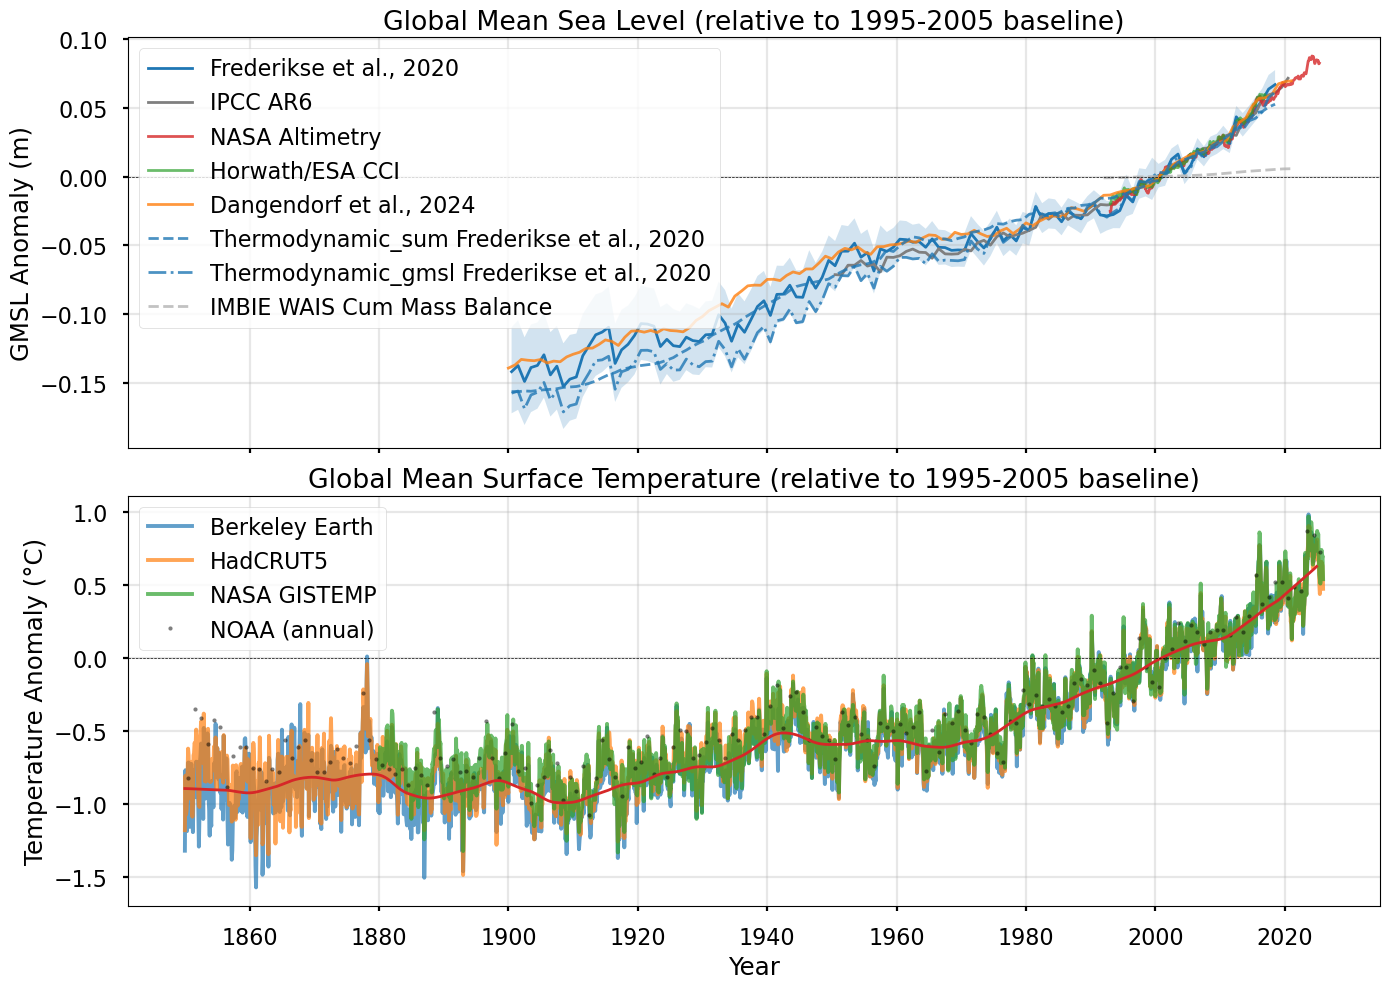

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# GMSL
ax1 = axes[0]
ax1.plot(df_frederikse_h.index, df_frederikse_h['gmsl'], 'tab:blue', lw=2, label='Frederikse et al., 2020')
ax1.fill_between(df_frederikse_h.index, df_frederikse_h['gmsl_lower'], df_frederikse_h['gmsl_upper'], alpha=0.2)
ax1.plot(df_ipcc_observed_gmsl_h.index, df_ipcc_observed_gmsl_h['gmsl'], 'tab:grey', lw=2, label='IPCC AR6')
ax1.plot(df_nasa_gmsl_h.index, df_nasa_gmsl_h['gmsl_smoothed'], 'tab:red', lw=2, label='NASA Altimetry', alpha=0.8)
ax1.plot(df_horwath_h.index, df_horwath_h['gmsl'], 'tab:green', lw=2, label='Horwath/ESA CCI', alpha=0.7)
ax1.plot(df_dangendorf_h.index, df_dangendorf_h['gmsl'],color='tab:orange', lw=2, label='Dangendorf et al., 2024', alpha=0.8)
ax1.plot(df_frederikse_thermo_h.index, df_frederikse_thermo_h['thermodynamic_sum'], '--',color='tab:blue', lw=2, label='Thermodynamic_sum Frederikse et al., 2020', alpha=0.8)
ax1.plot(df_frederikse_thermo_h.index, df_frederikse_thermo_h['thermodynamic_gmsl'], '-.',color='tab:blue', lw=2, label='Thermodynamic_gmsl Frederikse et al., 2020', alpha=0.8)
ax1.plot(df_imbie_wais_h.index, df_imbie_wais_h['cumulative_mass_balance'], '--',color='0.7', lw=2, label='IMBIE WAIS Cum Mass Balance', alpha=0.8)
ax1.axhline(0, color='k', lw=0.5, ls='--')
ax1.set_ylabel('GMSL Anomaly (m)')
ax1.set_title('Global Mean Sea Level (relative to 1995-2005 baseline)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Temperature
ax2 = axes[1]
ax2.plot(df_berkeley_h.index, df_berkeley_h['temperature'], label='Berkeley Earth', alpha=0.7)
ax2.plot(df_hadcrut_h.index, df_hadcrut_h['temperature'], label='HadCRUT5', alpha=0.7)
ax2.plot(df_gistemp_h.index, df_gistemp_h['temperature'], label='NASA GISTEMP', alpha=0.7)
ax2.plot(df_noaa_h.index, df_noaa_h['temperature'], 'ko', ms=3, label='NOAA (annual)', alpha=0.5)
ax2.plot(df_berkeley_h.index, sm.nonparametric.lowess(df_berkeley_h['temperature'],df_berkeley_h.index,frac=0.075)[:,1],'tab:red',lw=2)
ax2.axhline(0, color='k', lw=0.5, ls='--')
ax2.set_ylabel('Temperature Anomaly (°C)')
ax2.set_xlabel('Year')
ax2.set_title('Global Mean Surface Temperature (relative to 1995-2005 baseline)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/gmsl_gmst_overview.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 SLR Cummulative, Rates, and Accelerations

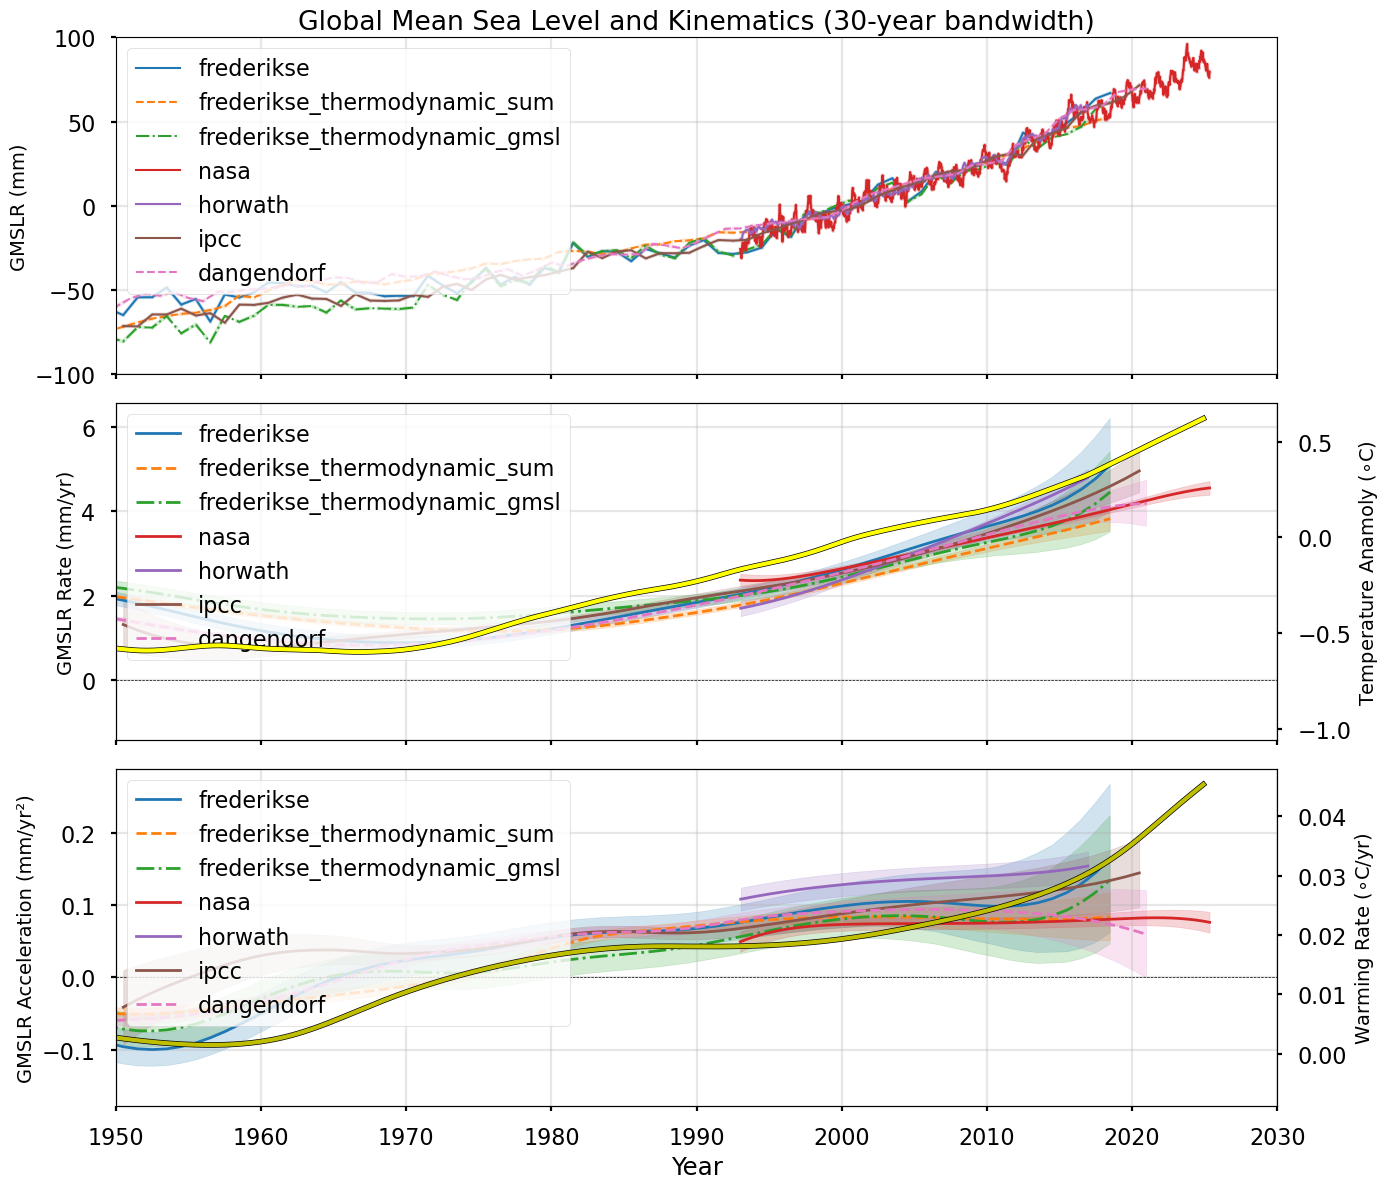

In [37]:
# -----------------------------------------------------------------------------
# PLOT: SLR Cummulative, Rates, and Accelerations
# -----------------------------------------------------------------------------

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
label_fontsize = 14

# Color scheme for datasets
colors = {
    'frederikse': 'C0',
    'frederikse_thermodynamic_sum' : 'C1',
    'frederikse_thermodynamic_gmsl' : 'C2',
    'nasa': 'C3', 
    'horwath': 'C4',
    'ipcc': 'C5',
    'dangendorf': 'C6'
}

linestyles = {
    'frederikse': '-',
    'frederikse_thermodynamic_sum' : '--',
    'frederikse_thermodynamic_gmsl' : '-.',
    'nasa': '-', 
    'horwath': '-',
    'ipcc': '-',
    'dangendorf': '--'
}

# ax1: GMSL data with fitted values
for name, res in kinematics.items():
    df = kinematics_dfs[name]
    valid = ~np.isnan(df['rate'])
    
    # Get original data
    if name == 'frederikse':
        orig_df = df_frederikse_h
        plot_type = 'gmsl'
    elif name == 'frederikse_thermodynamic_sum':
        orig_df = df_frederikse_thermo_h
        plot_type = 'thermodynamic_sum'
    elif name == 'frederikse_thermodynamic_gmsl':
        orig_df = df_frederikse_thermo_h
        plot_type = 'thermodynamic_gmsl'
    elif name == 'nasa':
        orig_df = df_nasa_gmsl_h
        plot_type = 'gmsl'
    elif name == 'horwath':
        orig_df = df_horwath_h
        plot_type = 'gmsl'
    elif name == 'ipcc':
        orig_df = df_ipcc_observed_gmsl_h
        plot_type = 'gmsl'
    elif name == 'dangendorf':
        orig_df = df_dangendorf_h
        plot_type = 'gmsl'

    # Plot original data (light)
    ax1.plot(df['decimal_year'], orig_df[plot_type].values * 1000, 
             'o', color=colors[name], ls=linestyles[name], alpha=0.2, markersize=2)
    # Plot would need fitted values - using smoothed rate integration as proxy
    ax1.plot(df.loc[valid, 'decimal_year'], orig_df.loc[valid.values, plot_type].values * 1000,
             color=colors[name], ls=linestyles[name], linewidth=1.5, label=name)

ax1.set_ylabel('GMSLR (mm)',fontsize=label_fontsize)
ax1.set_title(f'Global Mean Sea Level and Kinematics ({SPAN_YEARS}-year bandwidth)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([1950,2030])
ax1.set_ylim([-100,100])

ax22 = ax2.twinx()
berkeley_lowess_smooth = sm.nonparametric.lowess(df_berkeley_h['temperature'],df_berkeley_h.index,frac=0.1)[:,1]
ax22.plot(get_decimal_year(df_berkeley_h), berkeley_lowess_smooth,'k',lw=4)
ax22.plot(get_decimal_year(df_berkeley_h), berkeley_lowess_smooth,'yellow',lw=3)
ax22.set_ylabel('Temperature Anamoly ($\\circ$C)',fontsize=label_fontsize)
    
# ax2: Rates
for name, res in kinematics.items():
    df = kinematics_dfs[name]
    valid = ~np.isnan(df['rate'])
    rate_mm = df['rate'] * 1000
    rate_se_mm = df['rate_se'] * 1000
    
    ax2.plot(df.loc[valid, 'decimal_year'], rate_mm[valid], 
             ls=linestyles[name], color=colors[name], linewidth=2, label=name)
    ax2.fill_between(df.loc[valid, 'decimal_year'], 
                     (rate_mm - 1.96*rate_se_mm)[valid],
                     (rate_mm + 1.96*rate_se_mm)[valid],
                     color=colors[name], alpha=0.2)

ax2.set_ylabel('GMSLR Rate (mm/yr)',fontsize=label_fontsize)
ax2.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([1950,2030])

# ax3: Accelerations
ax33 = ax3.twinx()
df = gmst_kinematics_dfs['berkeley']
valid = ~np.isnan(df['rate'])
gmst_rate = df['rate']

ax33.plot(df.loc[valid, 'decimal_year'],gmst_rate, ls='-',color='k',lw=4)
ax33.plot(df.loc[valid, 'decimal_year'],gmst_rate, ls='-',color='y',lw=3, label='Berkeley Earth GMST')
ax33.set_ylabel('Warming Rate ($\\circ$C/yr)',fontsize=label_fontsize)

for name, res in kinematics.items():
    df = kinematics_dfs[name]
    valid = ~np.isnan(df['accel'])
    accel_mm = df['accel'] * 1000
    accel_se_mm = df['accel_se'] * 1000
    
    ax3.plot(df.loc[valid, 'decimal_year'], accel_mm[valid],
             ls=linestyles[name], color=colors[name], linewidth=2, label=name)
    ax3.fill_between(df.loc[valid, 'decimal_year'],
                     (accel_mm - 1.96*accel_se_mm)[valid],
                     (accel_mm + 1.96*accel_se_mm)[valid],
                     color=colors[name], alpha=0.2)

ax3.set_ylabel('GMSLR Acceleration (mm/yr²)',fontsize=label_fontsize)
ax3.set_xlabel('Year')
ax3.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([1950,2030])

plt.tight_layout()
plt.savefig('figures/gmsl_kinematics.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.3 Rate vs. Temperature Phase Plot



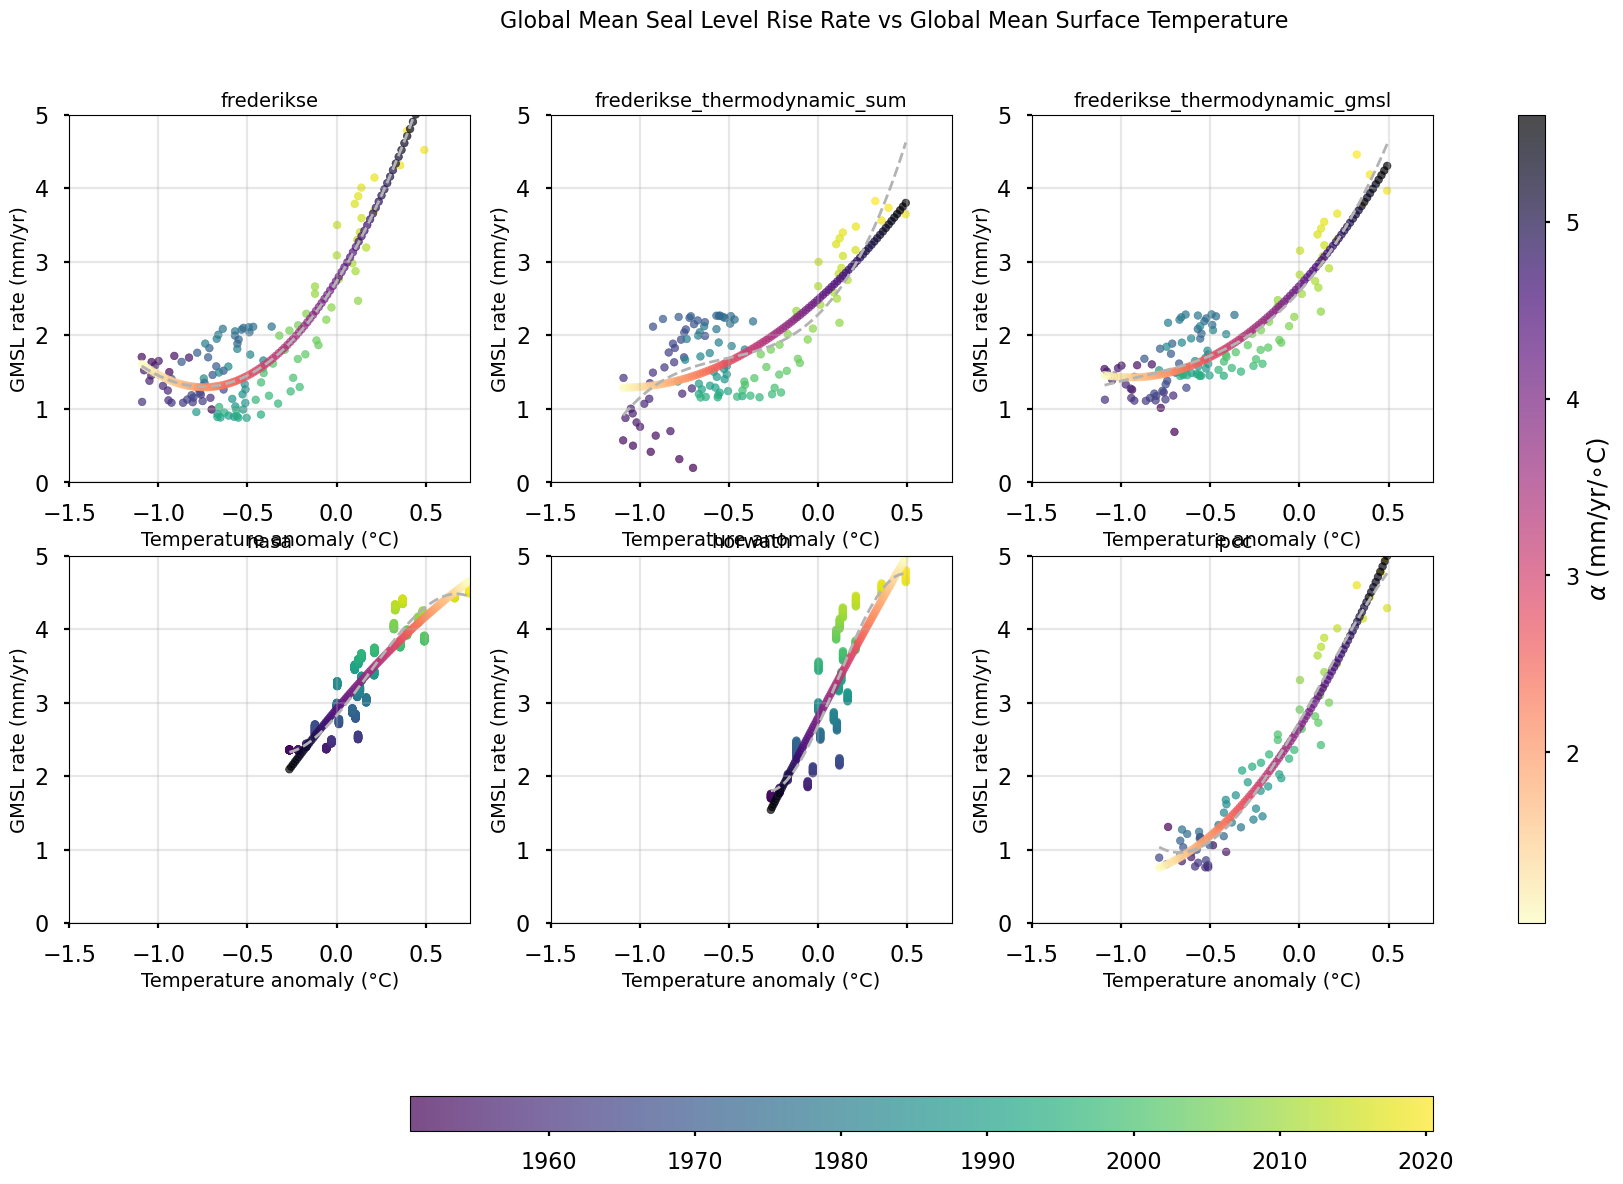

In [38]:
# -----------------------------------------------------------------------------
# PLOT: Rate vs Temperature phase plot
# -----------------------------------------------------------------------------

# Resample Berkeley Earth to annual for matching
df_berkeley_annual = df_berkeley_h.resample('YE').mean()
df_berkeley_annual['decimal_year'] = df_berkeley_annual.index.year + 0.5

fig, axes = plt.subplots(2, 3, figsize=(22, 15))
axes = axes.flatten()

label_fontsize = 14

for i, (name, res) in enumerate(kinematics.items()):
    if i >= 6:
        break
    
    df_kin = kinematics_dfs[name]
    valid = ~np.isnan(df_kin['rate'])
    
    # Match time points with temperature
    kin_years = df_kin.loc[valid, 'decimal_year'].values
    rate_mm = df_kin.loc[valid, 'rate'].values * 1000
    
    # Find matching temperature values
    temp_matched = []
    rate_matched = []
    time_matched = []
    
    for year, rate in zip(kin_years, rate_mm):
        # Find closest temperature year
        temp_idx = np.argmin(np.abs(df_berkeley_annual['decimal_year'].values - year))
        if np.abs(df_berkeley_annual['decimal_year'].values[temp_idx] - year) < 1.0:
            temp_matched.append(df_berkeley_annual['temperature'].values[temp_idx])
            rate_matched.append(rate)
            time_matched.append(year)
    
    temp_matched = np.array(temp_matched)
    rate_matched = np.array(rate_matched)
    time_matched = np.array(time_matched)
    
    # Scatter plot colored by time
    sc = axes[i].scatter(temp_matched, rate_matched, c=time_matched, 
                         cmap='viridis', s=30, alpha=0.7)
    
    # Linear fit for α estimation
    if len(temp_matched) > 10:
        mask = ~(np.isnan(temp_matched) | np.isnan(rate_matched))
        if mask.sum() > 10:
            z = np.polyfit(temp_matched[mask], rate_matched[mask], 2)
            p = np.poly1d(z)
            temp_range = np.linspace(temp_matched[mask].min(), temp_matched[mask].max(), 100)
            #axes[i].plot(temp_range, p(temp_range), 'r--', linewidth=2, 
            #            label=f"{z[0]:.1f}$\\Delta T^2$ + {z[1]:.1f}$\\Delta T$...") #label=f'$\\alpha$ ≈ {z[1]:.1f} mm/yr/°C')
            sr = axes[i].scatter(temp_range, p(temp_range), c=np.gradient(p(temp_range),temp_range),
                            cmap='magma_r', s=30, alpha=0.7)
            z = np.polyfit(temp_matched[mask], rate_matched[mask], 3)
            p = np.poly1d(z)
            temp_range = np.linspace(temp_matched[mask].min(), temp_matched[mask].max(), 100)
            axes[i].plot(temp_range, p(temp_range), '--',color='0.7', linewidth=2) 
            #            label=f"{z[0]:.1f}$\\Delta T^3$ + {z[1]:.1f}$\\Delta T^2$ + {z[2]:.1f}$\\Delta T$...")

    axes[i].set_xlim([-1.5,0.75])
    axes[i].set_ylim([0,5])
    axes[i].set_xlabel('Temperature anomaly (°C)',fontsize=label_fontsize)
    axes[i].set_ylabel('GMSL rate (mm/yr)',fontsize=label_fontsize)
    axes[i].set_title(name,fontsize=label_fontsize)
    axes[i].grid(True, alpha=0.3)
    #axes[i].legend()

# Remove empty subplot if only 5 datasets
if len(kinematics) < 6:
    axes[-1].axis('off')
#print(plt.colorbar.__doc__)
plt.colorbar(sc, ax=axes, shrink=0.6, aspect=30, location='bottom', orientation='horizontal')
plt.colorbar(sr, ax=axes, shrink=1, aspect=30, label='$\\alpha$ (mm/yr/$\\circ$C)')
plt.suptitle('Global Mean Seal Level Rise Rate vs Global Mean Surface Temperature',fontsize=label_fontsize+2, y=0.95)
#plt.tight_layout()
plt.savefig('figures/rate_vs_temperature_phase.png', dpi=150, bbox_inches='tight')
plt.show()


---
## Data Summary

All variables produced by this notebook for downstream analysis notebooks.

In [39]:
# --DATA_SUMM-- ---------------------------------------------------------------
# Comprehensive catalog of all variables produced by this notebook
# -----------------------------------------------------------------------------

# --- Raw observed DataFrames ---
raw_obs = {
    'df_frederikse':        {'type': 'GMSL', 'period': f'{df_frederikse.index.min().year}–{df_frederikse.index.max().year}', 'res': 'Annual',  'n': len(df_frederikse)},
    'df_dangendorf':        {'type': 'GMSL', 'period': f'{df_dangendorf.index.min().year}–{df_dangendorf.index.max().year}', 'res': 'Annual',  'n': len(df_dangendorf)},
    'df_horwath':           {'type': 'GMSL', 'period': f'{df_horwath.index.min().strftime("%Y-%m")}–{df_horwath.index.max().strftime("%Y-%m")}', 'res': 'Monthly', 'n': len(df_horwath)},
    'df_nasa_gmsl':         {'type': 'GMSL', 'period': f'{df_nasa_gmsl.index.min().strftime("%Y-%m")}–{df_nasa_gmsl.index.max().strftime("%Y-%m")}', 'res': '10-day',  'n': len(df_nasa_gmsl)},
    'df_ipcc_observed_gmsl':{'type': 'GMSL', 'period': f'{df_ipcc_observed_gmsl.index.min().year}–{df_ipcc_observed_gmsl.index.max().year}', 'res': 'Annual',  'n': len(df_ipcc_observed_gmsl)},
    'df_imbie_wais':        {'type': 'WAIS', 'period': f'{df_imbie_wais.index.min().strftime("%Y-%m")}–{df_imbie_wais.index.max().strftime("%Y-%m")}', 'res': 'Monthly', 'n': len(df_imbie_wais)},
    'df_berkeley':          {'type': 'Temp', 'period': f'{df_berkeley.index.min().strftime("%Y-%m")}–{df_berkeley.index.max().strftime("%Y-%m")}', 'res': 'Monthly', 'n': len(df_berkeley)},
    'df_hadcrut':           {'type': 'Temp', 'period': f'{df_hadcrut.index.min().strftime("%Y-%m")}–{df_hadcrut.index.max().strftime("%Y-%m")}', 'res': 'Monthly', 'n': len(df_hadcrut)},
    'df_gistemp':           {'type': 'Temp', 'period': f'{df_gistemp.index.min().strftime("%Y-%m")}–{df_gistemp.index.max().strftime("%Y-%m")}', 'res': 'Monthly', 'n': len(df_gistemp)},
    'df_noaa':              {'type': 'Temp', 'period': f'{df_noaa.index.min().year}–{df_noaa.index.max().year}', 'res': 'Annual',  'n': len(df_noaa)},
}

# --- Baseline-harmonized DataFrames ---
harmonized = {
    'df_frederikse_h':        'GMSL, harmonized to 1995–2005',
    'df_nasa_gmsl_h':         'GMSL, harmonized to 1995–2005',
    'df_horwath_h':           'GMSL, harmonized to 1995–2005',
    'df_dangendorf_h':        'GMSL, harmonized to 1995–2005',
    'df_ipcc_observed_gmsl_h':'GMSL, harmonized to 1995–2005',
    'df_imbie_wais_h':        'WAIS cumulative mass balance, harmonized to 1995–2005',
    'df_berkeley_h':          'Temperature, harmonized to 1995–2005',
    'df_hadcrut_h':           'Temperature, harmonized to 1995–2005',
    'df_gistemp_h':           'Temperature, harmonized to 1995–2005',
    'df_noaa_h':              'Temperature, harmonized to 1995–2005',
}

# --- Derived DataFrames ---
derived = {
    'df_frederikse_thermo':   'Thermodynamic signal (steric + barystatic − TWS)',
    'df_frederikse_thermo_h': 'Thermodynamic signal, harmonized to 1995–2005',
}

# --- IPCC Projection dicts ---
projections = {
    'temp_projections': f'dict[scenario → DataFrame], scenarios: {list(temp_projections.keys())}',
    'ipcc_gmsl_proj':   f'dict[scenario → DataFrame], scenarios: {list(ipcc_gmsl_proj.keys())}',
}

# --- Kinematics ---
kinematics_info = {
    'kinematics':         f'dict[name → KinematicsResult], datasets: {list(kinematics.keys())}',
    'kinematics_dfs':     f'dict[name → DataFrame], same keys as kinematics',
    'gmst_kinematics':    f'dict[name → KinematicsResult], datasets: {list(gmst_kinematics.keys())}',
    'gmst_kinematics_dfs':f'dict[name → DataFrame], same keys as gmst_kinematics',
}

# --- Configuration constants ---
config = {
    'BASELINE':       BASELINE,
    'SPAN_YEARS':     SPAN_YEARS,
    'SEALEVEL_UNITS': SEALEVEL_UNITS,
    'TEMPERATURE_UNITS': TEMPERATURE_UNITS,
    'BASE_DIR':       str(BASE_DIR),
    'DATA_RAW_DIR':   str(DATA_RAW_DIR),
    'DATA_IPCC_DIR':  str(DATA_IPCC_DIR),
}

# --- Print summary tables ---
print("=" * 95)
print("RAW OBSERVED DATAFRAMES")
print("=" * 95)
print(f"{'Variable':<28} {'Type':<6} {'Period':<22} {'Res':<10} {'Records':>7}")
print("-" * 95)
for name, info in raw_obs.items():
    print(f"{name:<28} {info['type']:<6} {info['period']:<22} {info['res']:<10} {info['n']:>7}")

print(f"\n{'='*95}")
print("HARMONIZED DATAFRAMES  (baseline: 1995–2005)")
print("=" * 95)
for name, desc in harmonized.items():
    print(f"  {name:<30} {desc}")

print(f"\n{'='*95}")
print("DERIVED DATAFRAMES")
print("=" * 95)
for name, desc in derived.items():
    print(f"  {name:<30} {desc}")

print(f"\n{'='*95}")
print("IPCC PROJECTION DICTS")
print("=" * 95)
for name, desc in projections.items():
    print(f"  {name:<30} {desc}")

print(f"\n{'='*95}")
print(f"KINEMATICS  (bandwidth: {SPAN_YEARS} yr)")
print("=" * 95)
for name, desc in kinematics_info.items():
    print(f"  {name:<30} {desc}")

print(f"\n{'='*95}")
print("CONFIGURATION")
print("=" * 95)
for name, val in config.items():
    print(f"  {name:<25} = {val}")

RAW OBSERVED DATAFRAMES
Variable                     Type   Period                 Res        Records
-----------------------------------------------------------------------------------------------
df_frederikse                GMSL   1900–2018              Annual         119
df_dangendorf                GMSL   1900–2021              Annual         122
df_horwath                   GMSL   1993-01–2016-12        Monthly        288
df_nasa_gmsl                 GMSL   1993-01–2025-05        10-day        1191
df_ipcc_observed_gmsl        GMSL   1950–2020              Annual          71
df_imbie_wais                WAIS   1992-01–2020-12        Monthly        348
df_berkeley                  Temp   1850-01–2024-12        Monthly       2100
df_hadcrut                   Temp   1850-01–2025-12        Monthly       2112
df_gistemp                   Temp   1880-01–2025-12        Monthly       1752
df_noaa                      Temp   1850–2025              Annual         176

HARMONIZED DATAFRAMES

---
## Save Processed Data

Serialize all processed DataFrames, projection dicts, kinematics, and configuration
to HDF5 for fast, random-access loading in downstream analysis notebooks.

**Format: HDF5** (via `pd.HDFStore` / PyTables)

Advantages over pickle:
- **Random-access reads** — load individual DataFrames without deserializing the whole file
- **Compression** — `blosc:zstd` typically gives 2–4× size reduction
- **Cross-version stability** — less fragile across pandas/Python upgrades than pickle
- **Self-describing** — keys are browsable with `store.keys()`

**Usage in downstream notebooks:**
```python
import pandas as pd

store = pd.HDFStore('../data/processed/slr_processed_data.h5', mode='r')

# Browse available keys:
print(store.keys())

# Load individual DataFrames:
df_frederikse_h = store['harmonized/df_frederikse_h']
df_berkeley_h   = store['harmonized/df_berkeley_h']

# Load projection dicts (one key per scenario):
temp_ssp245 = store['projections/temp/SSP2_4_5']
ipcc_ssp245 = store['projections/gmsl/ssp245']

# Load kinematics:
kin_frederikse = store['kinematics/gmsl/frederikse']

# Load config (stored as a single-row DataFrame):
config = store['config']
BASELINE = tuple(config[['baseline_start', 'baseline_end']].values[0])

store.close()
```

In [40]:
# [SAVE-DATA] -----------------------------------------------------------------
# Save all processed data to HDF5 via pd.HDFStore
# -----------------------------------------------------------------------------
from datetime import datetime as _dt
import warnings

PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_FILE = PROCESSED_DIR / 'slr_processed_data.h5'
COMPLEVEL = 5
COMPLIB   = 'blosc:zstd'

# =============================================================================
# Write to HDF5
# =============================================================================
with pd.HDFStore(str(OUTPUT_FILE), mode='w', complevel=COMPLEVEL, complib=COMPLIB) as store:

    # --- Raw observed DataFrames ---
    for name, df in [
        ('df_frederikse',         df_frederikse),
        ('df_dangendorf',         df_dangendorf),
        ('df_horwath',            df_horwath),
        ('df_nasa_gmsl',          df_nasa_gmsl),
        ('df_ipcc_observed_gmsl', df_ipcc_observed_gmsl),
        ('df_imbie_wais',         df_imbie_wais),
        ('df_berkeley',           df_berkeley),
        ('df_hadcrut',            df_hadcrut),
        ('df_gistemp',            df_gistemp),
        ('df_noaa',               df_noaa),
    ]:
        store.put(f'raw/{name}', df)

    # --- Baseline-harmonized DataFrames ---
    for name, df in [
        ('df_frederikse_h',         df_frederikse_h),
        ('df_nasa_gmsl_h',          df_nasa_gmsl_h),
        ('df_horwath_h',            df_horwath_h),
        ('df_dangendorf_h',         df_dangendorf_h),
        ('df_ipcc_observed_gmsl_h', df_ipcc_observed_gmsl_h),
        ('df_imbie_wais_h',         df_imbie_wais_h),
        ('df_berkeley_h',           df_berkeley_h),
        ('df_hadcrut_h',            df_hadcrut_h),
        ('df_gistemp_h',            df_gistemp_h),
        ('df_noaa_h',               df_noaa_h),
    ]:
        store.put(f'harmonized/{name}', df)

    # --- Derived DataFrames ---
    store.put('derived/df_frederikse_thermo',   df_frederikse_thermo)
    store.put('derived/df_frederikse_thermo_h', df_frederikse_thermo_h)

    # --- IPCC Projections (one key per scenario) ---
    for scenario, df in temp_projections.items():
        store.put(f'projections/temp/{scenario}', df)
    for scenario, df in ipcc_gmsl_proj.items():
        # HDF5 keys can't contain '.' — replace dots in scenario names
        safe_key = scenario.replace('.', 'p')
        store.put(f'projections/gmsl/{safe_key}', df)

    # --- Kinematics (DataFrame representations) ---
    for name, df in kinematics_dfs.items():
        store.put(f'kinematics/gmsl/{name}', df)
    for name, df in gmst_kinematics_dfs.items():
        store.put(f'kinematics/gmst/{name}', df)

    # --- Configuration (as a single-row DataFrame for HDF5 compatibility) ---
    config_df = pd.DataFrame([{
        'baseline_start':    BASELINE[0],
        'baseline_end':      BASELINE[1],
        'span_years':        SPAN_YEARS,
        'sealevel_units':    SEALEVEL_UNITS,
        'temperature_units': TEMPERATURE_UNITS,
        'time_units':        TIME_UNITS,
    }])
    store.put('config', config_df)

    # --- Metadata ---
    meta_df = pd.DataFrame([{
        'created':          _dt.now().isoformat(),
        'source_notebook':  'read_process_datafiles.ipynb',
        'description':      'Processed SLR/GMST data for downstream analysis',
        'pandas_version':   pd.__version__,
        'numpy_version':    np.__version__,
    }])
    store.put('metadata', meta_df)

file_size_mb = OUTPUT_FILE.stat().st_size / (1024 * 1024)
print(f"Saved to: {OUTPUT_FILE}")
print(f"File size: {file_size_mb:.1f} MB  (blosc:zstd, level {COMPLEVEL})")

# =============================================================================
# Verify round-trip
# =============================================================================
with pd.HDFStore(str(OUTPUT_FILE), mode='r') as store:
    all_keys = store.keys()
    n_raw  = sum(1 for k in all_keys if k.startswith('/raw/'))
    n_harm = sum(1 for k in all_keys if k.startswith('/harmonized/'))
    n_derv = sum(1 for k in all_keys if k.startswith('/derived/'))
    n_proj = sum(1 for k in all_keys if k.startswith('/projections/'))
    n_kin  = sum(1 for k in all_keys if k.startswith('/kinematics/'))

    print(f"\nVerification — {len(all_keys)} keys in HDF5 store:")
    print(f"  raw:          {n_raw} DataFrames")
    print(f"  harmonized:   {n_harm} DataFrames")
    print(f"  derived:      {n_derv} DataFrames")
    print(f"  projections:  {n_proj} DataFrames  (temp + gmsl scenarios)")
    print(f"  kinematics:   {n_kin} DataFrames  (gmsl + gmst)")
    print(f"  config:       {store['config'].to_dict(orient='records')[0]}")
    print(f"  metadata:     created {store['metadata']['created'].values[0]}")

    # Spot-check a harmonized DataFrame
    _check = store['harmonized/df_frederikse_h']
    print(f"\n  Spot-check: harmonized/df_frederikse_h → {_check.shape}, "
          f"columns={list(_check.columns)[:5]}...")

# Also delete the old pickle file if it exists
old_pkl = PROCESSED_DIR / 'slr_processed_data.pkl'
if old_pkl.exists():
    old_pkl.unlink()
    print(f"\nRemoved old pickle file: {old_pkl}")

Saved to: ../data/processed/slr_processed_data.h5
File size: 3.5 MB  (blosc:zstd, level 5)

Verification — 48 keys in HDF5 store:
  raw:          10 DataFrames
  harmonized:   10 DataFrames
  derived:      2 DataFrames
  projections:  16 DataFrames  (temp + gmsl scenarios)
  kinematics:   8 DataFrames  (gmsl + gmst)
  config:       {'baseline_start': 1995, 'baseline_end': 2005, 'span_years': 30, 'sealevel_units': 'm', 'temperature_units': 'c', 'time_units': 'y'}
  metadata:     created 2026-02-10T20:17:47.654091

  Spot-check: harmonized/df_frederikse_h → (119, 45), columns=['year', 'gmsl_lower', 'gmsl', 'gmsl_upper', 'sum_contributors_lower']...
